# Extended data figure 1

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

## Evolution Engine


In [22]:
def get_payoff_and_coop(p, q, b1, b2, c, eps, mode='stochastic'):
    """
    Calculates long-term payoffs and cooperation rates for resident p vs mutant q.
    Solves an 8-state Markov chain: (Env1, CC, CD, DC, DD) and (Env2, CC, CD, DC, DD).
    """
    # Factor in execution error epsilon
    p_eff = p * (1 - 2 * eps) + eps
    q_eff = q * (1 - 2 * eps) + eps
    
    # 8x8 Transition Matrix M
    M = np.zeros((8, 8))
    opp_idx = {0: 0, 1: 2, 2: 1, 3: 3} # Maps opponent's memory-one indices
    
    for s in range(8):
        env_idx = s // 4
        c1 = p_eff[s]
        # Opponent's choice depends on the current environment and their perspective
        c2 = q_eff[env_idx * 4 + opp_idx[s % 4]]
        
        # Outcome probabilities: CC, CD, DC, DD
        probs = [c1 * c2, c1 * (1 - c2), (1 - c1) * c2, (1 - c1) * (1 - c2)]
        for act, prob in enumerate(probs):
            if mode == 'stochastic':
                # Core Mechanism: Only mutual cooperation (CC) returns to Game 1
                next_env = 0 if act == 0 else 1 
            elif mode == 'only_game1': 
                next_env = 0
            else: 
                next_env = 1
            
            M[s, next_env * 4 + act] = prob

    # Find the stationary distribution (eigenvector of eigenvalue 1)
    vals, vecs = np.linalg.eig(M.T)
    v = vecs[:, np.isclose(vals, 1.0)].real[:, 0]
    v /= v.sum()
    
    # Define payoff vectors for Game 1 and Game 2
    u1 = np.array([b1 - c, -c, b1, 0])
    u2 = np.array([b2 - c, -c, b2, 0])
    
    # Calculate resident payoff
    pi_p = np.dot(v[:4], u1) + np.dot(v[4:], u2)
    
    # Calculate mutant payoff (swap CD/DC payoffs for the mutant's perspective)
    u1_m = np.array([b1 - c, b1, -c, 0])
    u2_m = np.array([b2 - c, b2, -c, 0])
    pi_q = np.dot(v[:4], u1_m) + np.dot(v[4:], u2_m)
    
    # Return resident payoff, mutant payoff, and resident cooperation rate
    return pi_p, pi_q, np.dot(v, p_eff)

def get_fixation_probability(pi_m, pi_r, pi_mm, pi_rm, n_pop, beta):
    """
    Calculates the exact fixation probability in a finite population.
    pi_m: mutant vs resident payoff
    pi_r: resident vs resident payoff
    pi_mm: mutant vs mutant payoff
    pi_rm: resident vs mutant payoff
    """
    diffs = []
    for j in range(1, n_pop):
        # f_m: mutant fitness at frequency j/N
        f_m = ((j - 1) * pi_mm + (n_pop - j) * pi_m) / (n_pop - 1)
        # f_r: resident fitness at frequency (N-j)/N
        f_r = (j * pi_rm + (n_pop - j - 1) * pi_r) / (n_pop - 1)
        diffs.append(f_r - f_m)
    
    # Sum of selection differences for the fixation probability formula
    exponent_sums = np.cumsum(beta * np.array(diffs))
    return 1.0 / (1.0 + np.sum(np.exp(np.clip(exponent_sums, -500, 500))))

## Simulation

In [23]:
def run_simulation_core(params):
    """
    General simulation function.
    Runs a single evolutionary simulation based on the provided parameters.
    """
    # Unpack parameters
    mode = params['mode']
    b1 = params['b1']
    b2 = params['b2']
    c = params['c']
    beta = params['beta']
    eps = params['eps']
    N = params['N']
    steps = params['steps']
    strat_type = params.get('strat_type', 'pure') # 'pure' or 'stochastic'
    
    # Initialize strategy (Resident always starts as AllD - Pure Defection)
    # Using AllD as a baseline facilitates evolution.
    res_strat = np.zeros(8) 
    
    # Define the start of the steady state (last 20% of steps)
    steady_state_start = int(steps * 0.8) 
    total_coop = 0.0
    
    for t in range(steps):
        # --- Key Modification: Support for Stochastic Strategies (Fig b) ---
        if strat_type == 'pure':
            # Pure strategy: Integers 0 or 1
            mut_strat = np.random.randint(0, 2, 8).astype(np.float64)
        else:
            # Stochastic strategy: Floating point numbers between 0.0 and 1.0
            mut_strat = np.random.random(8)
        # ----------------------------------
        
        # Calculate Payoffs
        # 1. Resident vs Resident
        pi_rr, _, _ = get_payoff_and_coop(res_strat, res_strat, b1, b2, c, eps, mode)
        # 2. Resident vs Mutant / Mutant vs Resident
        pi_rm, pi_mr, _ = get_payoff_and_coop(res_strat, mut_strat, b1, b2, c, eps, mode)
        # 3. Mutant vs Mutant
        pi_mm, _, _ = get_payoff_and_coop(mut_strat, mut_strat, b1, b2, c, eps, mode)
        
        # Calculate Fixation Probability
        p_fix = get_fixation_probability(pi_mr, pi_rr, pi_mm, pi_rm, N, beta)
        
        # Evolutionary Step
        if np.random.rand() < p_fix:
            res_strat = mut_strat
            
        # Statistics Collection
        # Accumulate cooperation levels only during the steady state
        if t >= steady_state_start:
            _, _, curr_coop = get_payoff_and_coop(res_strat, res_strat, b1, b2, c, eps, mode)
            total_coop += curr_coop
            
    # Return average cooperation level during steady state
    return total_coop / (steps - steady_state_start)

from joblib import Parallel, delayed

def run_sweep(param_name, values, ax, title, strat_type='pure', n_jobs=-1):
    """
    Orchestrates the parameter sweep simulation and plotting.
    Uses joblib for parallel processing.
    
    Parameters:
    - n_jobs: Number of parallel jobs. Use -1 for all available cores.
    """
    print(f"Sweeping {param_name} ({strat_type})...")
    
    # Base parameters (Default values from Fig 2a)
    base_params = {
        'b1': 2.0, 'b2': 1.2, 'c': 1.0, 
        'beta': 1.0, 'eps': 0.001, 
        'N': 100, 'steps': 5000,
        'strat_type': strat_type
    }
    
    modes = ['stochastic', 'only_game1', 'only_game2']
    colors = ["green", "blue", "red"]
    styles = ['o-', 's--', 's--']
    
    # Number of runs per data point
    RUNS_PER_POINT = 100 
    
    for i, mode in enumerate(modes):
        y_means = []
        # Iterate over parameter values with a progress bar
        for val in tqdm(values, desc=f"{mode[:4]}", leave=False):
            
            # Create parameter sets for all runs
            param_sets = []
            for _ in range(RUNS_PER_POINT):
                p = base_params.copy()
                p['mode'] = mode
                
                # Update the specific parameter being swept
                if param_name == 'b1': 
                    p['b1'] = val
                elif param_name == 'eps': 
                    p['eps'] = val
                elif param_name == 'beta': 
                    p['beta'] = val
                
                param_sets.append(p)
            
            # Run simulations in parallel using joblib
            results = Parallel(n_jobs=n_jobs)(
                delayed(run_simulation_core)(params) for params in param_sets
            )
            
            y_means.append(np.mean(results))
            
        # Plot the results
        ax.plot(values, y_means, styles[i], color=colors[i], 
                label=mode if param_name=='b1' else "", alpha=0.8)
    
    # Configure plot aesthetics
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_ylim(-0.05, 1.05)
    ax.grid(True, alpha=0.3)

### Execution

Sweeping b1 (pure)...


KeyboardInterrupt: 

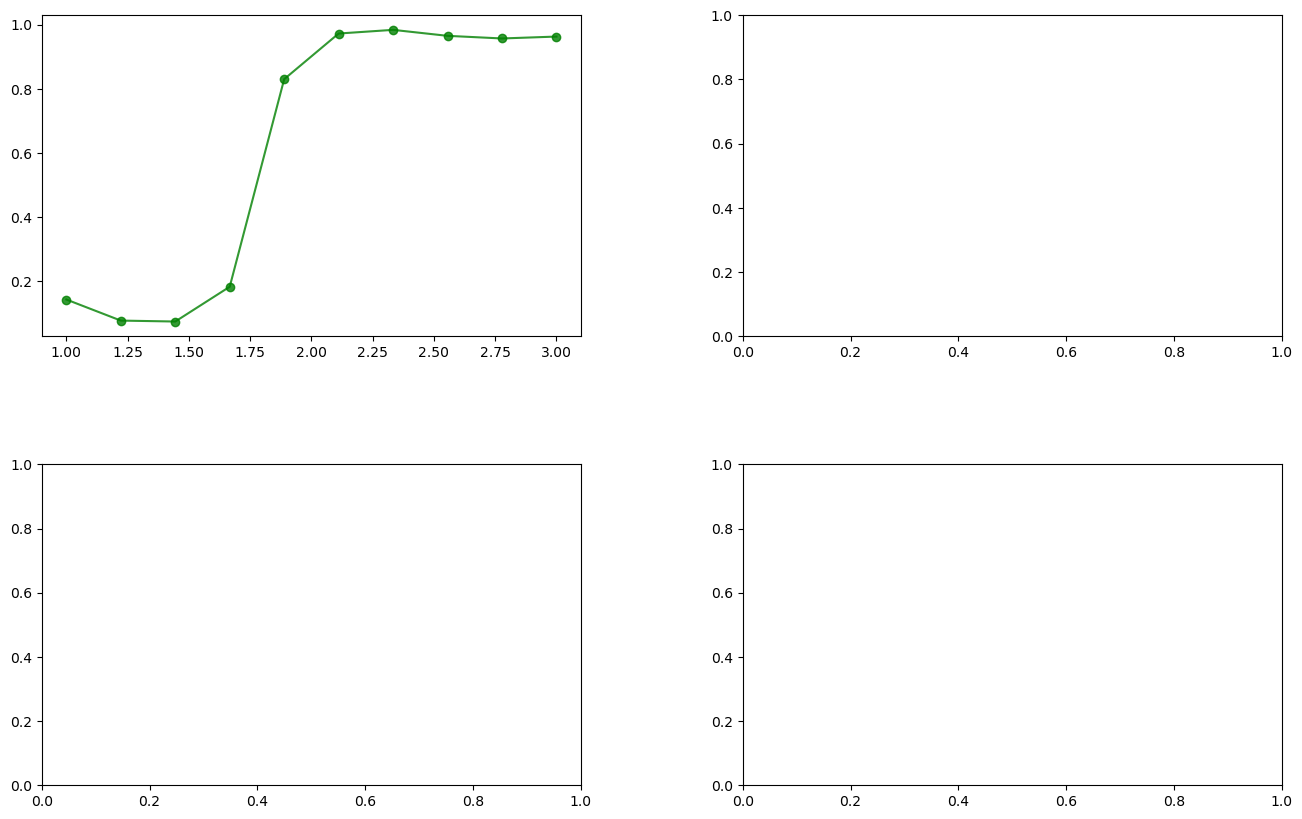

In [24]:
# Create a 2x2 subplot layout
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# Flatten axes array for easy indexing (0-3)
ax = axes.flatten()

# --- Fig a: Varying Benefit (Pure Strategies) ---
vals_b1 = np.linspace(1.0, 3.0, 10)
run_sweep('b1', vals_b1, ax[0], 'a. Pure strategies', strat_type='pure')
ax[0].set_ylabel('Cooperation rate')
ax[0].set_xlabel(r'Benefit in State 1 ($b_1$)')  # Added 'r'
ax[0].legend()

# --- Fig b: Varying Benefit (Stochastic Strategies) ---
# * Note: strat_type is set to 'stochastic' here *
run_sweep('b1', vals_b1, ax[1], 'b. Stochastic strategies', strat_type='stochastic')
ax[1].set_ylabel('Cooperation rate')
ax[1].set_xlabel(r'Benefit in State 1 ($b_1$)')  # Added 'r'

# --- Fig c: Error Rate (Pure) ---
vals_eps = np.logspace(-4, 0, 10)
run_sweep('eps', vals_eps, ax[2], r'c. Error rate $\epsilon$', strat_type='pure')  # Fixed: added 'r'
ax[2].set_xscale('log') # Logarithmic scale for x-axis
ax[2].set_xlabel(r'Error rate $\epsilon$')  # Fixed: added 'r'

# --- Fig d: Selection Strength (Pure) ---
vals_beta = np.logspace(-2, 2, 10)
run_sweep('beta', vals_beta, ax[3], r'd. Selection strength $\beta$', strat_type='pure')  # Fixed: added 'r'
ax[3].set_xscale('log') # Logarithmic scale for x-axis
ax[3].set_xlabel(r'Selection strength $\beta$')  # Fixed: added 'r'

print("\nGeneration Complete. Showing plot...")
plt.show()